# This is a notebook to evaluate the metrics of a given StarDist model, to see how it does compared to given ground truth data

In [156]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import matplotlib
matplotlib.rcParams["image.interpolation"] = None
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

from glob import glob
from tqdm import tqdm
from tifffile import imread
from csbdeep.utils import Path, normalize

from stardist import fill_label_holes, random_label_cmap, calculate_extents, gputools_available
from stardist import Rays_GoldenSpiral
from stardist.matching import matching, matching_dataset
from stardist.models import Config3D, StarDist3D, StarDistData3D

from skimage.segmentation import clear_border

import seaborn as sns
import matplotlib.pyplot as plt

np.random.seed(42)
lbl_cmap = random_label_cmap()

3407713138.py (5): Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.


In [40]:

import numpy as np
import pandas as pd
from collections import Counter
from timeit import default_timer as time

def timer_func(func):
    def wrapper(*args, **kwargs):
        start = time()
        result = func(*args, **kwargs)
        end = time()
        print(f'{func.__name__}() executed in {(end-start):.6f} s')
        # print(f'{(end - start):.6f}')
        return result
    return wrapper

def return_overlap_segmentation(Img_A, Img_B):
    """
    function to return the overlapping segmentation in two images
    :param Img_A:
    :param Img_B:
    :return: 3D image where overlapping pixels have Img_A labels
    """
    Img_temp = np.where([Img_B > 0], Img_A, Img_B)

    return Img_temp[0, :, :, :]

def return_non_zero_pixels_from_Image(Img):
    """
    return the coordinates of non-zero pixels in an image
    :param Img:
    :return: Array of coordinates ((x1, y1, z1), (x2, y2, z2), (x3, y3, z3), ...)
    """
    coords = np.nonzero(Img)
    overlap_pixels = np.transpose(coords)

    return overlap_pixels

def overlapping_objects(Img_A, Img_B):
    """
    finds coordinates of overlapping pixels then returns a list of corresponding labels from Img_A and Img_B paired
    up with one another at each overlapping pixel
    :param Img_A:
    :param Img_B:
    :return:
    """
    Img_compare = return_overlap_segmentation(Img_A, Img_B)
    overlap_pixels = return_non_zero_pixels_from_Image(Img_compare)
    
    A_objects = []
    B_objects = []
    
    for n in np.arange(len(overlap_pixels)):
        X, Y, Z = overlap_pixels[n]
        
        A_objects.append(Img_A[X, Y, Z])
        B_objects.append(Img_B[X, Y, Z])
    
    objs = list((zip(A_objects, B_objects)))

    return objs

def get_object_sizes(Img, Object_list):
    """
    finds size of object by getting label of each overlapping pixel and counting their occurrences
    :param Img:
    :param Object_list:
    :return: dict_object of label: number of occurrences
    """
    Img_Non_Zero_pixels = return_non_zero_pixels_from_Image(Img)

    Obj_count = []
    for n in np.arange(len(Img_Non_Zero_pixels)):
        X, Y, Z = Img_Non_Zero_pixels[n]
        Obj_count.append(Img[X, Y, Z])

    Obj_dict = Counter(Obj_count)
    Obj_dict = {k: Obj_dict[k] for k in Object_list}

    return Obj_dict

@timer_func
def create_overlap_df(Img_A, Img_B):
    """
    creates a dataframe of all overlapping objects in each image, with object size and percentage of overlap
    :param Img_A:
    :param Img_B:
    :return: pd.dataframe
    """
    objects_zip = overlapping_objects(Img_A, Img_B) #this is ordered so the objects will correspond
    
    objects_overlap_count = Counter(objects_zip)
    objects_set = objects_overlap_count.keys()
    objects_overlap_size = objects_overlap_count.values()
    
    A_objects = [ls[0] for ls in objects_set]
    B_objects = [ls[1] for ls in objects_set]
    
    A_overlap_size = list(objects_overlap_size)
    B_overlap_size = list(objects_overlap_size)
    
    A_obj_dict = get_object_sizes(Img_A, A_objects)
    B_obj_dict = get_object_sizes(Img_B, B_objects)
    
    Obj_A_size = []
    for obj in A_objects:
        Obj_A_size.append(A_obj_dict[obj])
    
    Obj_B_size = []
    for obj in B_objects:
        Obj_B_size.append(B_obj_dict[obj])    
    
    Overlap_Index = [n for n in np.arange(len(A_objects))]  # create overlap index
    
    data = {'Overlap_Index': Overlap_Index, 
       'Image_A_Object_ID': A_objects,
       'Image_B_Object_ID': B_objects,
       'Image_A_Object_Size': Obj_A_size,
       'Image_B_Object_Size': Obj_B_size,
       'Image_A_Overlap_Size': A_overlap_size,
       'Image_B_Overlap_Size': B_overlap_size}

    df = pd.DataFrame(data)
    assert(list(df['Image_A_Overlap_Size'])==list(df['Image_B_Overlap_Size'])) ## these should be identical
    df['Image_A_Overlap_PCT'] = df['Image_A_Overlap_Size']/df['Image_A_Object_Size']
    df['Image_B_Overlap_PCT'] = df['Image_B_Overlap_Size']/df['Image_B_Object_Size']
    
    return df

def combine_images(Img_A, Img_B):
    """
    combines two labelled images into one with continuity in label IDs
    :param Img_A:
    :param Img_B:
    :return: image with labels for segmentations from both images
    """
    Img_A[Img_A != 0] += np.max(Img_B)
    combined = Img_A + Img_B
    
    return combined


def pct_overlap_filter(df, pct):
    """
    removes objects with overlap less than the threshold percent from the overlapping objects dataframe
    :param Img_A:
    :param Img_B:
    :return: image with labels for segmentations from both images
    """
    df_filtered = df[df['Image_A_Overlap_PCT'] >= pct]
    return df_filtered

def check_dask():
    try:
        import dask.array as da
        return True
    except ImportError:
        return False

@timer_func
def remove_objects(image, objects, dask_bool):
    if dask_bool:
        print('dask found, using dask for parallelisation of removing overlapping objects')
        import dask.array as da
        Img = da.from_array(image, chunks=(1, 'auto', 'auto'))

        mask = np.isin(Img, objects).astype(int)
        Img_removed_dask = np.where(mask, 0, Img)
        Img_removed = Img_removed_dask.compute()
    else:
        print('dask not found, removing overlapping objects sequentially')
        mask = np.isin(image, objects).astype(int)
        Img_removed = np.where(mask, 0, image)
    return Img_removed


@timer_func
def seg_compare_df(ground_truth_labels, segmentation_labels):
    """
    creates a dataframe of all overlapping objects in each image, with object size and percentage of overlap
    :param Img_A: ground truth labels
    :param Img_B: segmentation labels
    :return: pd.dataframe
    """
    Img_A = ground_truth_labels
    Img_B = segmentation_labels
    objects_zip = overlapping_objects(Img_A, Img_B) #this is ordered so the objects will correspond
    
    objects_overlap_count = Counter(objects_zip)
    objects_set = objects_overlap_count.keys()
    objects_overlap_size = objects_overlap_count.values()
    
    A_objects = [ls[0] for ls in objects_set]
    B_objects = [ls[1] for ls in objects_set]
    
    A_overlap_size = list(objects_overlap_size)
    B_overlap_size = list(objects_overlap_size)
    
    A_obj_dict = get_object_sizes(Img_A, A_objects)
    B_obj_dict = get_object_sizes(Img_B, B_objects)
    
    Obj_A_size = []
    for obj in A_objects:
        Obj_A_size.append(A_obj_dict[obj])
    
    Obj_B_size = []
    for obj in B_objects:
        Obj_B_size.append(B_obj_dict[obj])    
    
    Overlap_Index = [n for n in np.arange(len(A_objects))]  # create overlap index
    
    data = {'Overlap_Index': Overlap_Index, 
       'Ground_Truth_Object_ID': A_objects,
       'Segmentation_Labels_Object_ID': B_objects,
       'Ground_Truth_Object_Size': Obj_A_size,
       'Segmentation_Labels_Object_Size': Obj_B_size,
       'Ground_Truth_Overlap_Size': A_overlap_size,
       'Segmentation_Labels_Overlap_Size': B_overlap_size}

    df = pd.DataFrame(data)
    assert(list(df['Ground_Truth_Overlap_Size'])==list(df['Segmentation_Labels_Overlap_Size'])) ## these should be identical
    df['Ground_Truth_Overlap_PCT'] = df['Ground_Truth_Overlap_Size']/df['Ground_Truth_Object_Size']
    df['Segmentation_Labels_Overlap_PCT'] = df['Segmentation_Labels_Overlap_Size']/df['Segmentation_Labels_Object_Size']
    
    return df



In [3]:

ground_truth_image_file = '/nemo/stp/lm/working/shared/vd_tf/Training_Data/Images/C3-JTGX25-3b_81-130C/C3-JTGX25-3b_81-130C.tif'
ground_truth_label_file = '/nemo/project/proj-lm-turnerj/StarDist_Stuff/Training_Data/Masks/C3-JTGX25-3b_81-130C.tif'
parseg_label_file = '/nemo/stp/lm/working/shared/vd_tf/Training_Data/Images/C3-JTGX25-3b_81-130C/LblImg_C3-JTGX25-3b_81-130C_15_60_combined.tif'

## Open the files

In [4]:
ground_truth_image = imread(ground_truth_image_file)
ground_truth_labels = imread(ground_truth_label_file)
parseg_labels = imread(parseg_label_file).astype(np.int16)

## Remove the segmentations that touch the border

### https://scikit-image.org/docs/stable/api/skimage.segmentation.html#skimage.segmentation.join_segmentations

In [25]:
ground_truth_labels_no_border = clear_border(ground_truth_labels)
parseg_labels_no_border = clear_border(parseg_labels)

## Let's get the number of spots to start

In [29]:
nSeg_ground_truth = np.max(ground_truth_labels)
nSeg_parseg_labels = np.max(parseg_labels)

nSeg_ground_truth_no_border = len(np.unique(ground_truth_labels_no_border))
nSeg_parseg_labels_no_border = len(np.unique(parseg_labels_no_border))

print("There are :", nSeg_parseg_labels, "parseg labels compared to :", nSeg_ground_truth, " ground truth labels")
print("There are :", nSeg_parseg_labels_no_border, " parseg labels that don't touch the border compared to :", nSeg_ground_truth_no_border, " ground truth labels that don't touch the border")

There are : 196 parseg labels compared to : 174  ground truth labels
There are : 139  parseg labels that don't touch the border compared to : 135  ground truth labels that don't touch the border


## Get the overlap dataframe

In [30]:
IoU_df = create_overlap_df(ground_truth_labels_no_border, parseg_labels_no_border)

create_overlap_df() executed in 1.185931 s


In [31]:
len(IoU_df)

175

In [33]:
IoU_df = IoU_df[IoU_df['Image_A_Overlap_PCT']>0.2]

In [35]:
IoU_df.head()

,Overlap_Index,Image_A_Object_ID,Image_B_Object_ID,Image_A_Object_Size,Image_B_Object_Size,Image_A_Overlap_Size,Image_B_Overlap_Size,Image_A_Overlap_PCT,Image_B_Overlap_PCT
0,0,8,36,797,518,352,352,0.441656,0.679537
1,1,10,38,981,1286,934,934,0.952090,0.726283
3,3,6,46,1526,795,747,747,0.489515,0.939623
4,4,15,43,1204,798,756,756,0.627907,0.947368
5,5,12,41,1185,1342,1101,1101,0.929114,0.820417


In [36]:
len(IoU_df)

118

## Now Run the metrics from StarDist (which work well in 2d)


100%|█████████████████████████████████████████████| 9/9 [00:01<00:00,  6.78it/s]


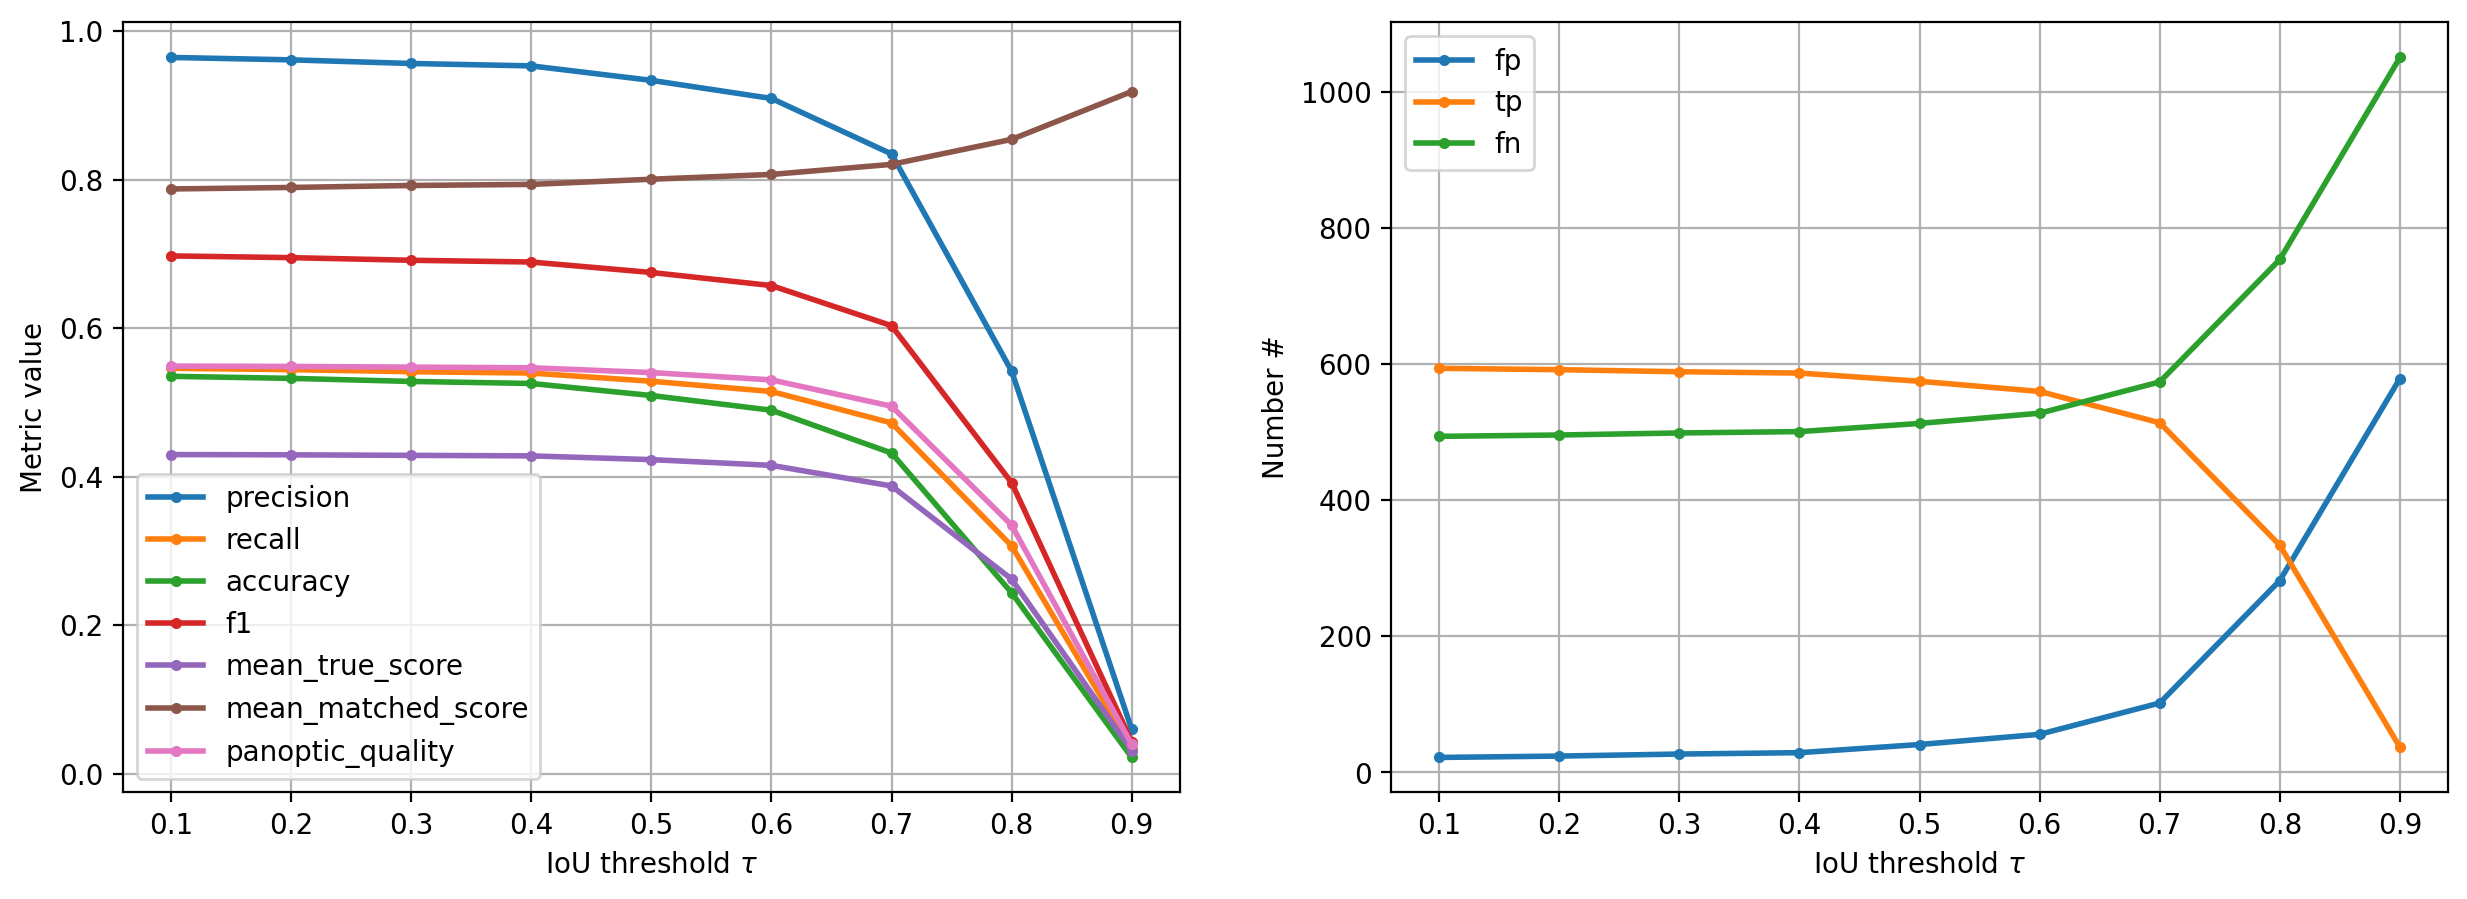

In [39]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#stats = [matching_dataset(y, predicted_image, thresh=t, show_progress=False) for t in tqdm(taus)]
stats = [matching_dataset(ground_truth_labels, parseg_labels, thresh=t, show_progress=False) for t in tqdm(taus)]
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In [48]:
ground_truth_labels.max()

174


100%|█████████████████████████████████████████████| 9/9 [00:06<00:00,  1.39it/s]


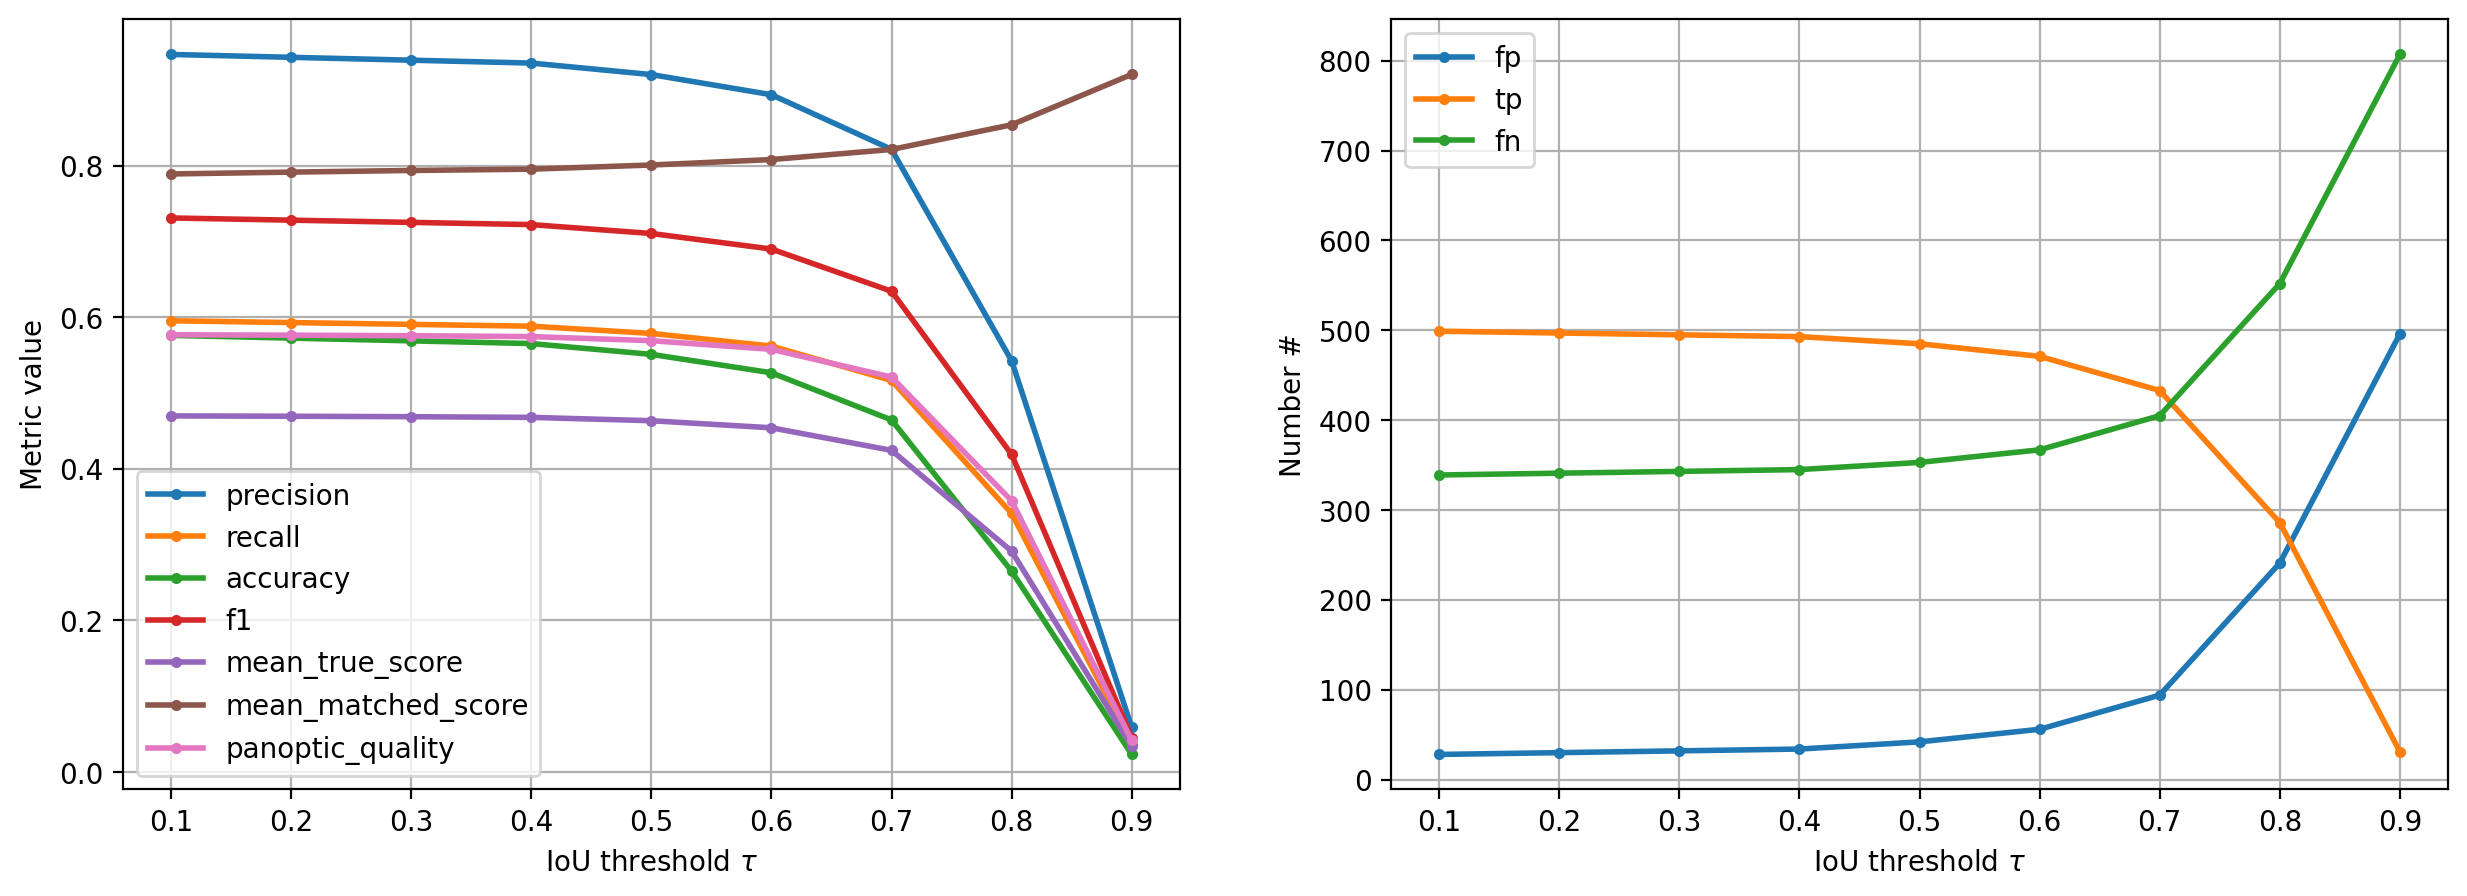

In [38]:
taus = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
#stats = [matching_dataset(y, predicted_image, thresh=t, show_progress=False) for t in tqdm(taus)]
stats = [matching_dataset(ground_truth_labels_no_border, parseg_labels_no_border, thresh=t, show_progress=False) for t in tqdm(taus)]
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(15,5))

for m in ('precision', 'recall', 'accuracy', 'f1', 'mean_true_score', 'mean_matched_score', 'panoptic_quality'):
    ax1.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax1.set_xlabel(r'IoU threshold $\tau$')
ax1.set_ylabel('Metric value')
ax1.grid()
ax1.legend()

for m in ('fp', 'tp', 'fn'):
    ax2.plot(taus, [s._asdict()[m] for s in stats], '.-', lw=2, label=m)
ax2.set_xlabel(r'IoU threshold $\tau$')
ax2.set_ylabel('Number #')
ax2.grid()
ax2.legend();

In [115]:
SegCompare_df = seg_compare_df(ground_truth_labels_no_border, parseg_labels_no_border)

seg_compare_df() executed in 1.200295 s


In [116]:
SegCompare_df.head()

,Overlap_Index,Ground_Truth_Object_ID,Segmentation_Labels_Object_ID,Ground_Truth_Object_Size,Segmentation_Labels_Object_Size,Ground_Truth_Overlap_Size,Segmentation_Labels_Overlap_Size,Ground_Truth_Overlap_PCT,Segmentation_Labels_Overlap_PCT
0,0,8,36,797,518,352,352,0.441656,0.679537
1,1,10,38,981,1286,934,934,0.952090,0.726283
2,2,15,36,1204,518,15,15,0.012458,0.028958
3,3,6,46,1526,795,747,747,0.489515,0.939623
4,4,15,43,1204,798,756,756,0.627907,0.947368


To do a proper true positive, we need to come up with a way to measure the overlap in both the objects, if they have some x% of overlap, we count it as a true positive. 

If there are two objects that exist, if it's in the parseg but not the ground truth, it's a false positive. If it's in the ground truth but not the parseg labels, it's a false negative. 

That's pretty much it. 


In [117]:
def matching3D(ground_truth_labels, segmentation_labels, threshold):
    #create the data frame and do the thresholding
    SegCompare_df = seg_compare_df(ground_truth_labels, segmentation_labels)
    SegCompare_df_thresh= SegCompare_df[SegCompare_df['Ground_Truth_Overlap_PCT']>threshold]
    SegCompare_df_thresh= SegCompare_df_thresh[SegCompare_df_thresh['Segmentation_Labels_Overlap_PCT']>threshold]
    
    #get a list of all the labels
    ground_truth_labels_list = list(np.unique(ground_truth_labels))
    segmentation_labels_list = list(np.unique(segmentation_labels))
    ground_truth_labels_list = [x for x in ground_truth_labels_list if x >= 1]
    segmentation_labels_list = [x for x in segmentation_labels_list if x >= 1]
    #get a list of the thresholded labels, and make sure they don't have the background as a label
    segmentation_labels_matched = list(SegCompare_df_thresh['Segmentation_Labels_Object_ID'])
    ground_truth_labels_matched = list(SegCompare_df_thresh['Ground_Truth_Object_ID'])
    ground_truth_labels_matched = [x for x in ground_truth_labels_matched if x >= 1]
    segmentation_labels_matched = [x for x in segmentation_labels_matched if x >= 1]
    
    
    # find out the true positives, i.e. the number of segmentation labels that are unique and matched a ground truth
    tp_list = list(np.unique(SegCompare_df_thresh['Segmentation_Labels_Object_ID']))
    
    # find out the false positives, the number of segmentation labels that exist but don't match a ground truth
    false_positive_list = [x for x in segmentation_labels_list if x not in segmentation_labels_matched]
    
    #find out the false negatives, the number of ground truth labels that exist, but didn't match a seg label
    false_negative_list = [x for x in ground_truth_labels_list if x not in ground_truth_labels_matched]
    
    tp = len(np.unique(tp_list))
    fp = len(np.unique(false_positive_list))
    fn = len(np.unique(false_negative_list))
    
    return tp, fp, fn, tp_list, false_positive_list, false_negative_list
    
    
    

In [144]:
tp, fp, fn, tp_list, false_positive_list, false_negative_list =  matching3D(ground_truth_labels_no_border, parseg_labels_no_border, 0.2)

seg_compare_df() executed in 1.126591 s


In [145]:
def matching_stats(tp, fp, fn):
    precision = tp/(tp+fp)
    recall = tp/(tp+fn)
    accuracy = tp/(tp+fp+fn)
    f1 = (2*tp)/((2*tp)+fp+fn)
    
    return precision, recall, accuracy, f1


In [146]:
precision, recall, accuracy, f1  = matching_stats(tp, fp, fn)

In [147]:
print(" Precision is: ", precision, "\n", "Recall is: ", recall, "\n", "accuracy is: ", accuracy, "\n", "f1 is: ", f1)

 Precision is:  0.8478260869565217 
 Recall is:  0.8796992481203008 
 accuracy is:  0.7597402597402597 
 f1 is:  0.8634686346863468


## Loop over thresholds

In [150]:
thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]
tps = []
fps = []
fns = []
precisions = []
recalls = []
accuracys = []
f1s = []

for threshold in thresholds:
    tp, fp, fn, tp_list, false_positive_list, false_negative_list = matching3D(ground_truth_labels_no_border, parseg_labels_no_border, threshold)
    tps.append(tp)
    fps.append(fp)
    fns.append(fn)
    precision, recall, accuracy, f1  = matching_stats(tp, fp, fn)
    precisions.append(precision)
    recalls.append(recall)
    accuracys.append(accuracy)
    f1s.append(f1)
    
    

seg_compare_df() executed in 1.162638 s
seg_compare_df() executed in 1.166137 s
seg_compare_df() executed in 1.181928 s
seg_compare_df() executed in 1.164872 s
seg_compare_df() executed in 1.198812 s
seg_compare_df() executed in 1.168776 s
seg_compare_df() executed in 1.167519 s
seg_compare_df() executed in 1.175937 s
seg_compare_df() executed in 1.146686 s
seg_compare_df() executed in 1.146721 s


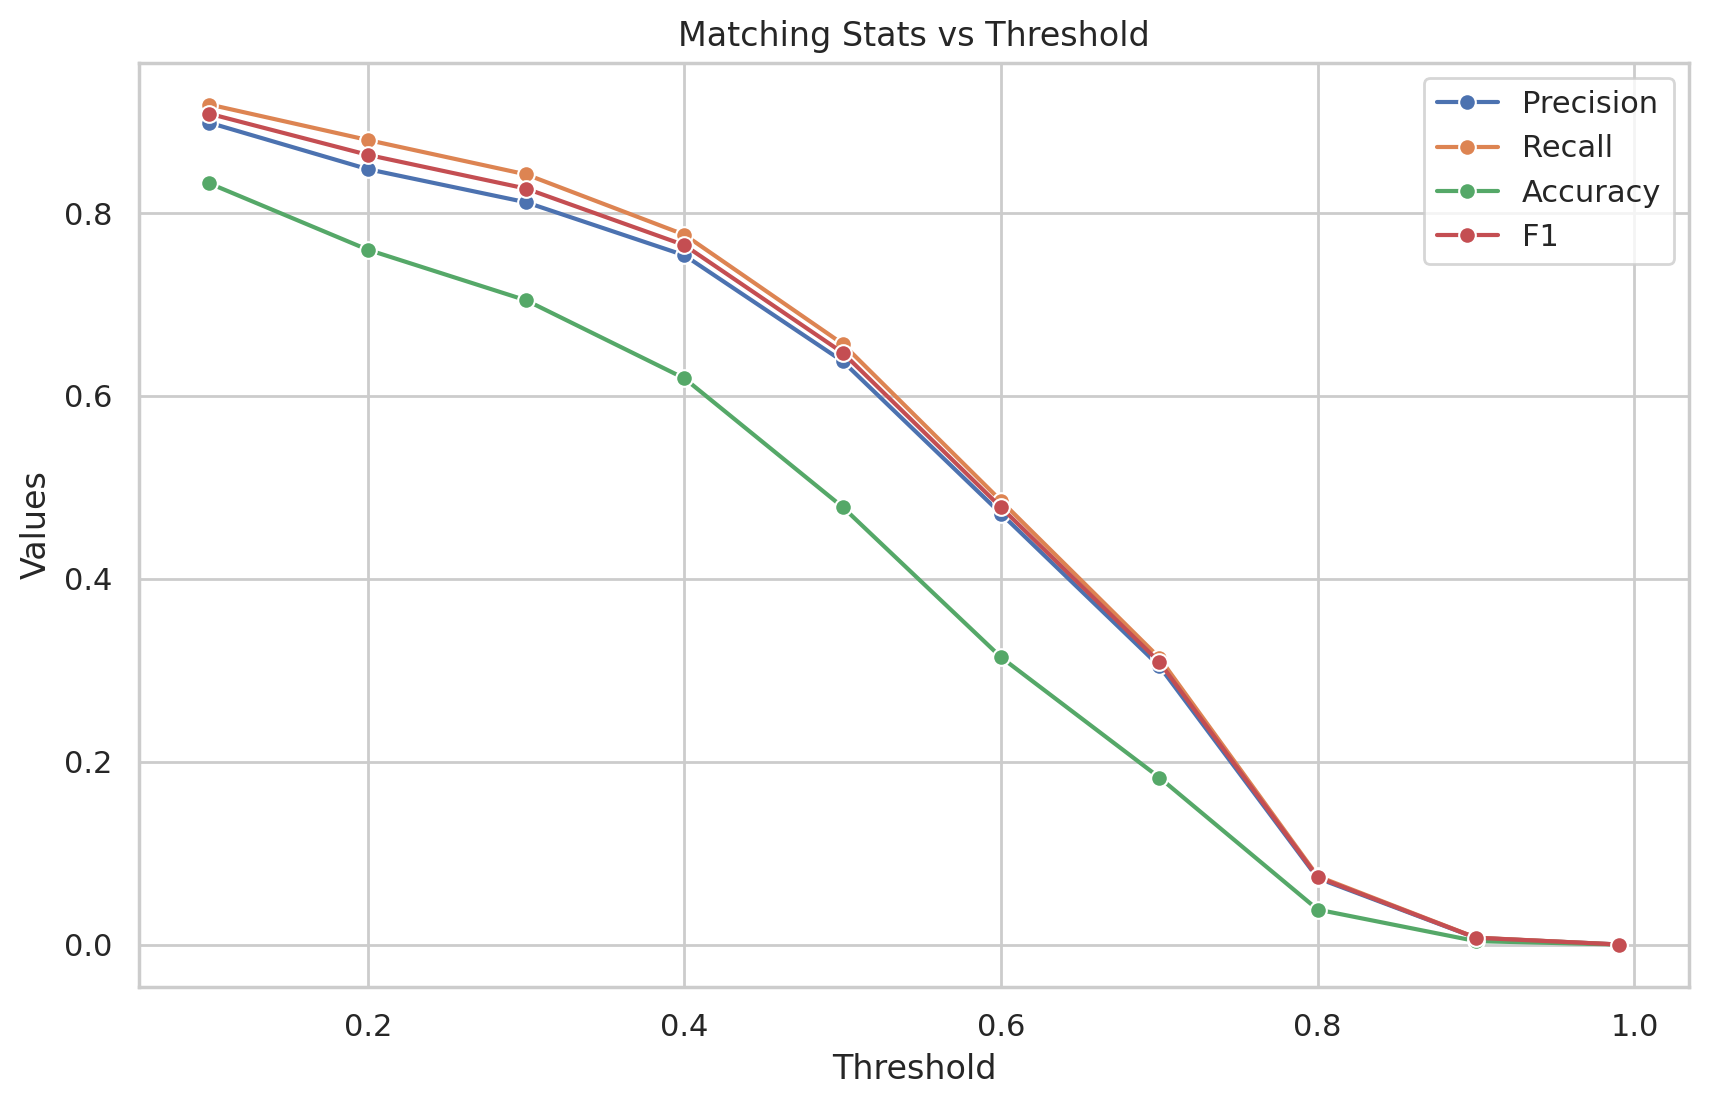

In [157]:


# Convert the data into a pandas DataFrame
df = pd.DataFrame({
    'Precision': precisions,
    'Recall': recalls,
    'Accuracy': accuracys,
    'F1': f1s, 
    'Threshold': thresholds
})

# Set the theme for the plots
sns.set_theme(style="whitegrid")

# Create a figure with subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot height vs. age
sns.lineplot(x='Threshold', y='Precision', data=df, ax=ax, label='Precision', marker='o')

# Plot weight vs. age
sns.lineplot(x='Threshold', y='Recall', data=df, ax=ax, label='Recall', marker='o')

# Plot blood pressure vs. age
sns.lineplot(x='Threshold', y='Accuracy', data=df, ax=ax, label='Accuracy', marker='o')

sns.lineplot(x='Threshold', y='F1', data=df, ax=ax, label='F1', marker='o')

# Set the labels and title
ax.set_xlabel('Threshold')
ax.set_ylabel('Values')
ax.set_title('Matching Stats vs Threshold')

# Display the legend
ax.legend()

# Show the plot
plt.show()


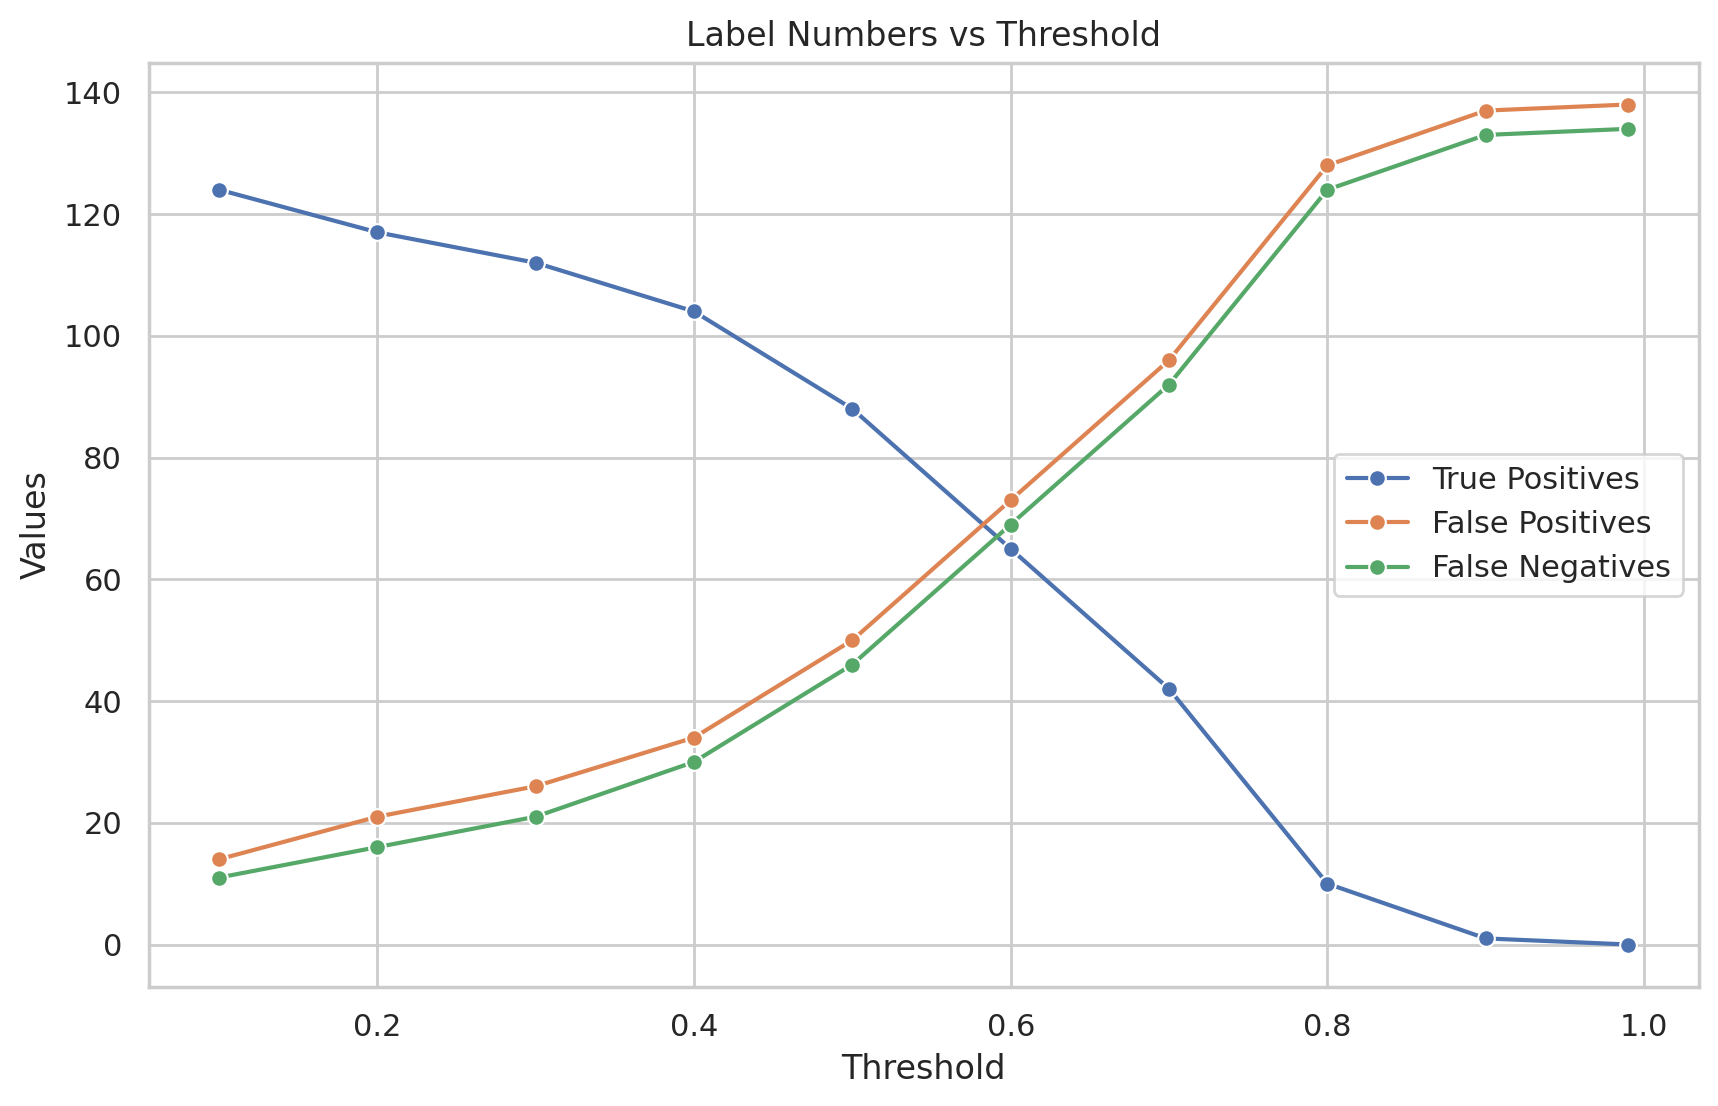

In [159]:
# Convert the data into a pandas DataFrame
df = pd.DataFrame({
    'True_Positives': tps,
    'False_Positives': fps,
    'False_Negatives': fns,
    'Threshold': thresholds
})

# Set the theme for the plots
sns.set_theme(style="whitegrid")

# Create a figure with subplots
fig, ax = plt.subplots(figsize=(10, 6))

# Plot height vs. age
sns.lineplot(x='Threshold', y='True_Positives', data=df, ax=ax, label='True Positives', marker='o')

# Plot weight vs. age
sns.lineplot(x='Threshold', y='False_Positives', data=df, ax=ax, label='False Positives', marker='o')

# Plot blood pressure vs. age
sns.lineplot(x='Threshold', y='False_Negatives', data=df, ax=ax, label='False Negatives', marker='o')


# Set the labels and title
ax.set_xlabel('Threshold')
ax.set_ylabel('Values')
ax.set_title('Label Numbers vs Threshold')

# Display the legend
ax.legend()

# Show the plot
plt.show()

For all true postitives, find the amount of matching pixels, and that's the TRUE true positives
Then find the number of pixels that were assigned as false negatives, and find the number that were assigned as false positives